In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU device:',torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('No GPU avaialable, Using CPU')

torch.cuda.set_device(0)

GPU device: Tesla V100-SXM2-32GB


In [2]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

set_seeds(42)

# Defining Uniform distribution per batch:
 - N = Number of samples per batch = batch size = 1024
 - C = Number of categories = 2
 - Perfectly Uniform Distribution per batch = N/C = 1024/2 = 512
 - Allocate the Integer part to each category.

In [3]:
import numpy as np

def create_uniform_distribution(batch_size, num_categories):
    ideal_fractional_count = batch_size / num_categories
    base_count = int(ideal_fractional_count)  # Integer part
    remainder = ideal_fractional_count - base_count  # Fractional part

    # Initialize distribution with the base count
    distribution = np.full(num_categories, base_count)

    # Calculate how many samples are left to distribute
    samples_left = batch_size - np.sum(distribution)

    # Distribute the remaining samples
    for _ in range(samples_left):
        min_index = np.argmin(distribution - (base_count + remainder))
        distribution[min_index] += 1

    return distribution

ideal_uniform = create_uniform_distribution(1024, 2)
print(ideal_uniform)
print("Total:", np.sum(ideal_uniform))  # Should be 1024

[512 512]
Total: 1024


# But our last batch contains only 793 images. 

- So for last batch we need to have a different Uniform distribution for the comparison. 

In [4]:
import numpy as np

def create_uniform_distribution(batch_size, num_categories):
    ideal_fractional_count = batch_size / num_categories
    base_count = int(ideal_fractional_count)  # Integer part
    remainder = ideal_fractional_count - base_count  # Fractional part

    # Initialize distribution with the base count
    distribution = np.full(num_categories, base_count)

    # Calculate how many samples are left to distribute
    samples_left = batch_size - np.sum(distribution)

    # Distribute the remaining samples
    for _ in range(samples_left):
        min_index = np.argmin(distribution - (base_count + remainder))
        distribution[min_index] += 1

    return distribution

# for standard batches
ideal_uniform_standard = create_uniform_distribution(1024, 2)

# for the last batch
ideal_uniform_last_batch = create_uniform_distribution(793, 2)
print(ideal_uniform_last_batch)
print("Total:", np.sum(ideal_uniform_last_batch))

[397 396]
Total: 793


# Normalized Uniform Distribution:

In [5]:
def create_uniform_distribution(batch_size, num_categories):
    ideal_fractional_count = batch_size / num_categories
    # Integer part
    base_count = int(ideal_fractional_count)
    # Fraction Part - Last batch should contain samples less than 1024 - Exact 793 Samples
    remainder = ideal_fractional_count - base_count
    # Initialize distribution with the base count
    distribution = np.full(num_categories, base_count)
    # Calculate how many samples are left to distribute
    samples_left = batch_size - np.sum(distribution)

    for _ in range(samples_left):
        min_index = np.argmin(distribution - (base_count + remainder))
        distribution[min_index] += 1

    # Normalize the distribution to make it a probability distribution
    normalized_uniform_distribution = distribution / np.sum(distribution)

    return normalized_uniform_distribution

# for the last batch
ideal_uniform_last_batch = create_uniform_distribution(793, 2)
print(ideal_uniform_last_batch)
print("Total:", np.sum(ideal_uniform_last_batch))

[0.50063052 0.49936948]
Total: 1.0


# KL Divergence Calculation:
* The KL divergence from distribution Q to P is defined as:

$$ D_{\text{KL}}(P || Q) = \sum_{i} P(i) \log\left(\frac{P(i)}{Q(i)}\right) $$

Where $P(i)$ and  $Q(i)$ are the probabilities of the $ith$ event in distributions $P$ and $Q$, respectively.

* Ensure that there are no zero probabilities in your distributions when calculating the KL divergence. If necessary, apply smoothing (e.g., add a small constant to all probabilities).
* The KL divergence is not symmetric.
* A lower KL divergence value indicates a distribution that is closer to the uniform distribution.

# 1. Determine the KL divergence between the (Uniform Distribution per batch per category) & (Dataloader 1 distribution per batch per category)

# 2. Determine the KL divergence between the (Uniform Distribution per batch per category) & (Dataloader 2 distribution per batch per category)

# 0.001

In [6]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import cumfreq
import pickle
import pandas as pd
from scipy.stats import entropy
from collections import Counter

from b_weightedimagedataset import WeightedImageDataset

from sklearn.metrics.pairwise import cosine_similarity
import hdbscan

import torchvision
from torchvision.datasets import ImageFolder


CATEGORY_MAPPING = {
    '_non_distracted': 0, 'distracted': 1
}

class DataLoaderComparisonKL:
    def __init__(self, feature_file_path, label_file_path, img_path_file_path, num_categories, batch_size):
        self.batch_size = batch_size
        self.num_categories = num_categories
        self.features, self.labels, self.img_paths = self.load_data(feature_file_path, label_file_path, img_path_file_path)
        self.dataloader_a, self.dataloader_b, self.weights_list, self.pred_labels_b, self.pred_cluster_counts = self.initialize_dataloaders()

    def load_data(self, feature_file_path, label_file_path, img_path_file_path):
        with open(feature_file_path, 'rb') as file:
            features = pickle.load(file)
        with open(label_file_path, 'rb') as file:
            labels = pickle.load(file)
        with open(img_path_file_path, 'rb') as file:
            img_paths = pickle.load(file)
        return features, labels, img_paths

    def initialize_dataloaders(self):
        # CustomImageDataset and WeightedImageDataset initialization
        transform_a = transforms.Compose([
                transforms.Resize((224, 224)),  # Resize the image to a fixed size (224x224)
                transforms.ToTensor(),          # Convert the image to a PyTorch tensor
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],  # Normalize the image channels (mean)
                    std=[0.229, 0.224, 0.225]    # Normalize the image channels (std)
                )
            ])
        dataset_a = ImageFolder(root='/net/polaris/storage/deeplearning/sur_data/binary_rgb_daa/split_0/train', transform=transform_a)
        dataloader_a = DataLoader(dataset_a, batch_size=self.batch_size, shuffle=True, num_workers=10, drop_last=False)

        # Batch conversion of precomputed features, Batches = 254, Batch Size 1024, Feature size: [1,1280]
        features_loader = [self.features[i:i+1024] for i in range(0, len(self.features), 1024)]
        gt_labels_loader = [self.labels[i:i+1024] for i in range(0, len(self.labels), 1024)]

        # Get the weights
        weights_list, pred_labels_b, pred_cluster_counts = self.process_batches(features_loader)
        dataset_b = WeightedImageDataset(self.img_paths, weights_list, gt_labels_loader)
        sampler_b = WeightedRandomSampler(dataset_b.weights, num_samples=len(dataset_b.weights), replacement=True)
        dataloader_b = DataLoader(dataset_b, batch_size=self.batch_size, sampler=sampler_b, num_workers=10)

        return dataloader_a, dataloader_b, weights_list, pred_labels_b, pred_cluster_counts
    
    def compute_weights_cosine_dist(self, features):
        cosine_dist_matrix = 1 - cosine_similarity(features).astype(np.float64)
        # Using Updated HDBSCAN for clustering with tuned Hyperparameters
        clusterer = hdbscan.HDBSCAN(min_cluster_size=25, 
                                    min_samples=1, 
                                    cluster_selection_epsilon=0.0, 
                                    metric='precomputed', 
                                    cluster_selection_method='eom', 
                                    allow_single_cluster=False)
        # clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric='precomputed', cluster_selection_method='eom')
        labels = clusterer.fit_predict(cosine_dist_matrix)

        weights = np.zeros_like(labels, dtype=float)
        unique_labels = np.unique(labels)
        noise_label = -1
        # Initialize variables for managing the new outlier clusters
        max_label = labels.max()
        current_outlier_cluster_label = max_label + 1
        outlier_cluster_count = 0

        for label in unique_labels:
            if label == noise_label:
                # Process each noise point
                for noise_index in np.where(labels == noise_label)[0]:
                    # Assign it to the current outlier cluster
                    labels[noise_index] = current_outlier_cluster_label
                    outlier_cluster_count += 1
                    weights[noise_index] = 0.02  # Assign weight as 0.001 Exp9

                    # If the outlier cluster reaches its max size, move to a new one
                    if outlier_cluster_count >= 50:
                        current_outlier_cluster_label += 1
                        outlier_cluster_count = 0
            else:
                # For non-noise points, distribute weights evenly within clusters
                indices = np.where(labels == label)[0]
                weights[indices] = 1.0 / len(indices)

        total_clusters = len(np.unique(labels)) - 1  # Exclude the original noise label

        return weights, labels, total_clusters

    def process_batches(self, dataloader):
        all_weights = []
        all_labels = []
        all_cluster_counts = []

        for batch_features in dataloader:
            weights, labels, total_clusters = self.compute_weights_cosine_dist(batch_features)
            all_weights.append(weights)
            all_labels.append(labels)
            all_cluster_counts.append(total_clusters)

        return all_weights, all_labels, all_cluster_counts

    def track_category_counts_a(self, dataloader_a):
        # The shape of the array is defined by two dimensions: 
        # the number of batches in the DataLoader (len(dataloader_a)): 254 and 
        # the number of categories (self.num_categories) : 2.
        category_counts_a = np.zeros((len(dataloader_a), self.num_categories))

        for batch_idx, (_, targets) in enumerate(dataloader_a):
            for category in range(self.num_categories):
                category_counts_a[batch_idx, category] = torch.sum(targets == category).item()

        return category_counts_a
    
    def track_category_counts_b(self, dataloader_b):
        # Example Shape for a batch size of 1024 : [254,34]
        category_counts_b = np.zeros((len(dataloader_b), self.num_categories))

        for batch_idx, (_,_, targets,_) in enumerate(dataloader_b):
            for category in range(self.num_categories):
                category_counts_b[batch_idx, category] = torch.sum(targets == category).item()

        return category_counts_b
    
    ################### Uniform distribution for Comparison ####################

    def create_uniform_distribution(self, batch_size):
        ideal_fractional_count = batch_size / self.num_categories
        # Integer part
        base_count = int(ideal_fractional_count)
        # Fraction Part - Last batch should contain samples less than 1024 - Exact 793 Samples
        remainder = ideal_fractional_count - base_count
        # Initialize distribution with the base count
        distribution = np.full(self.num_categories, base_count)
        # Calculate how many samples are left to distribute
        samples_left = batch_size - np.sum(distribution)

        for _ in range(samples_left):
            min_index = np.argmin(distribution - (base_count + remainder))
            distribution[min_index] += 1

        # Normalize the distribution to make it a probability distribution
        normalized_uniform_distribution = distribution / np.sum(distribution)

        return normalized_uniform_distribution
    
    #################### KL Divergence Calculation #########################

    def kl_divergence(self, p, q):
        return entropy(p, q)

    def calculate_kl_divergences(self, counts, batch_sizes):
        kl_divergences = []
        for i, batch_count in enumerate(counts):
            uniform_dist = self.create_uniform_distribution(batch_sizes[i])
            normalized_count = batch_count / np.sum(batch_count)
            kl_div = self.kl_divergence(normalized_count, uniform_dist)
            kl_divergences.append(kl_div)

        return np.array(kl_divergences)
    
    ################# Counting for Visualisation ##########################
        
    #  Our Goal is to track the uniqueness of each image (i.e., each instance) 
    #  rather than just the class variety, using the image path is a much more 
    #  appropriate choice to track the count of unique images.
    def track_images_and_most_picked_samples(self, dataloader):
        unique_images_seen = set()
        unique_images_seen_per_batch = []
        most_picked_per_batch = []
        overall_counter = Counter()

        for _, _, _, paths in dataloader:
            # Track unique images
            unique_images_seen.update(paths)
            unique_images_seen_per_batch.append(len(unique_images_seen))

            # Track most picked samples per batch
            if len(paths) > 0:
                batch_counter = Counter(paths)
                most_common, count = batch_counter.most_common(1)[0]
                most_picked_per_batch.append((most_common, count))
            else:
                most_picked_per_batch.append((None, 0))

            # Update overall counter for most picked sample overall
            overall_counter.update(paths)

        # Determine the most picked sample overall
        most_common_overall, most_common_count_overall = overall_counter.most_common(1)[0]

        # Total unique samples seen
        total_unique_samples_seen = len(unique_images_seen)

        return unique_images_seen_per_batch, total_unique_samples_seen, most_picked_per_batch, (most_common_overall, most_common_count_overall)

    ################### Save the Results ######################################

    def save_results_to_pickle(self, data, file_name):
        with open(file_name, 'wb') as file:
            pickle.dump(data, file)
    
    #################### Visualisation Functions Here #########################
    
    def plot_kl_divergences(self, kl_divergences_a, kl_divergences_b):
        plt.figure(figsize=(12, 6))
        plt.plot(kl_divergences_a, label='DataLoader1')
        plt.plot(kl_divergences_b, label='DataLoader2')
        plt.xlabel('Batch Number')
        plt.ylabel('KL Divergence')
        plt.title('KL Divergence Comparison Between Two DataLoaders')
        plt.legend()
        plt.show()

    def plot_most_picked_samples_bar(self, most_picked_per_batch):
        sample_counts = Counter(most_picked_per_batch)
        samples, counts = zip(*sample_counts.items())

        plt.figure(figsize=(12, 6))
        plt.bar(samples, counts)
        plt.title("Frequency of Most Picked Samples")
        plt.xlabel("Sample")
        plt.ylabel("Frequency")
        plt.xticks(rotation=90)  # Rotate labels for better readability
        plt.show()

    def plot_unique_samples_scatter(self, unique_samples_seen_per_batch):
        plt.figure(figsize=(10, 6))
        plt.scatter(range(len(unique_samples_seen_per_batch)), unique_samples_seen_per_batch)
        plt.title("Cumulative Unique Samples Seen per Batch")
        plt.xlabel("Batch")
        plt.ylabel("Cumulative Unique Samples")
        plt.show()

    def plot_category_counts_boxplot(self, category_counts, y_lim=None):
        plt.figure(figsize=(12, 8))
        sns.boxplot(data=category_counts)
        plt.title("Box Plot of Category Counts per Batch")
        plt.xlabel("Category")
        plt.ylabel("Counts")

        if y_lim is not None:
            plt.ylim(y_lim)
        plt.show()

    def compare_dataloaders_and_save(self, save_path):
        counts_a = self.track_category_counts_a(self.dataloader_a)
        counts_b = self.track_category_counts_b(self.dataloader_b)

        batch_sizes = [1024] * (len(counts_a) - 1) + [793]  # Update as per your batch sizes
        kl_divergences_a = self.calculate_kl_divergences(counts_a, batch_sizes)
        kl_divergences_b = self.calculate_kl_divergences(counts_b, batch_sizes)
        b_unique_images_per_batch, b_total_unique_samples, b_most_picked_per_batch, tuple_most_common_sample = self.track_images_and_most_picked_samples(self.dataloader_b)

        # Save the results
        self.save_results_to_pickle(counts_a, f'{save_path}/counts_a.pkl')
        self.save_results_to_pickle(counts_b, f'{save_path}/counts_b.pkl')
        self.save_results_to_pickle(kl_divergences_a, f'{save_path}/kl_divergences_a.pkl')
        self.save_results_to_pickle(kl_divergences_b, f'{save_path}/kl_divergences_b.pkl')
        self.save_results_to_pickle(b_unique_images_per_batch, f'{save_path}/b_unique_images_per_batch.pkl')
        self.save_results_to_pickle(b_total_unique_samples, f'{save_path}/b_total_unique_samples.pkl')
        self.save_results_to_pickle(b_most_picked_per_batch, f'{save_path}/b_most_picked_per_batch.pkl')
        self.save_results_to_pickle(tuple_most_common_sample, f'{save_path}/tuple_most_common_sample.pkl')

        return counts_a, counts_b, kl_divergences_a, kl_divergences_b, b_unique_images_per_batch, b_total_unique_samples, b_most_picked_per_batch, tuple_most_common_sample

/home/sur06423/miniconda3/envs/dinov2/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
# Define file paths and parameters
feature_file_path = '/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/src/components/distraction_detection_d_b/clustering_experiments/features_split_0_kinect_rgb/all_split_0_rgb_features.pkl'
label_file_path = '/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/src/components/distraction_detection_d_b/clustering_experiments/features_split_0_kinect_rgb/all_split_0_rgb_labels.pkl'
img_path_file_path = '/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/src/components/distraction_detection_d_b/clustering_experiments/features_split_0_kinect_rgb/all_split_0_rgb_imagepaths.pkl'
num_categories = 2
batch_size = 1024
save_path = '/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/src/components/distraction_detection_d_b/KL_results/KL_0_02'

# Create an instance of DataLoaderComparisonKL and perform the comparison
comparison_kl = DataLoaderComparisonKL(feature_file_path, label_file_path, img_path_file_path, num_categories, batch_size)
counts_a, counts_b, kl_divergences_a, kl_divergences_b, b_unique_images_per_batch, b_total_unique_samples, b_most_picked_per_batch, tuple_most_common_sample = comparison_kl.compare_dataloaders_and_save(save_path)

# Analysis of KL Divergence Plot:

- General Trend: Both lines on the plot represent the KL divergence for each batch. DataLoader1 is depicted in blue and DataLoader2 in orange. The vertical axis represents the KL divergence values, and the horizontal axis corresponds to the batch numbers.

- DataLoader1 (Blue Line): The KL divergence values for DataLoader1 fluctuate around 0.08 and above, indicating a greater divergence from the uniform distribution compared to DataLoader2. This suggests that the category distribution in each batch for DataLoader1 is less uniform, with category 1 being over- and category 0 being under-represented.

- DataLoader2 (Orange Line): The KL divergence values for DataLoader2 are generally lower, fluctuating around 0.01. This suggests that the sample distribution in DataLoader2 is closer to the uniform distribution, indicating a more balanced representation of categories within each batch.

# Final Interpretation:

- Balanced Sampling: DataLoader2 appears to have a more balanced sampling approach, leading to batches that are more uniformly distributed across categories when compared to DataLoader1. This is due to the use of a weighted sampling strategy that aims to equalize the representation of categories across batches.

- Consistency: The consistency of DataLoader2 in maintaining lower KL divergence values across batches suggests a stable and predictable sampling behavior. In contrast, DataLoader1 shows more imbalance, which could lead to less stable training behavior if used in a machine learning/ deep learning context.

- Suitability for Machine/Deep Learning: The goal is to have a balanced and unbiased representation of categories in each batch, DataLoader2 might be more suitable for training machine/deep learning models, as it could help prevent the models from overfitting to over-represented categories.

- Potential Overfitting: The higher KL divergence in DataLoader1 may result in models trained with this data being less generalizable due to potential overfitting to the categories that are disproportionately represented.

# Conclusion:

* We're aiming for a balanced and uniform representation of categories in our training batches, DataLoader2 seems to be the better choice based on the KL divergence plot.

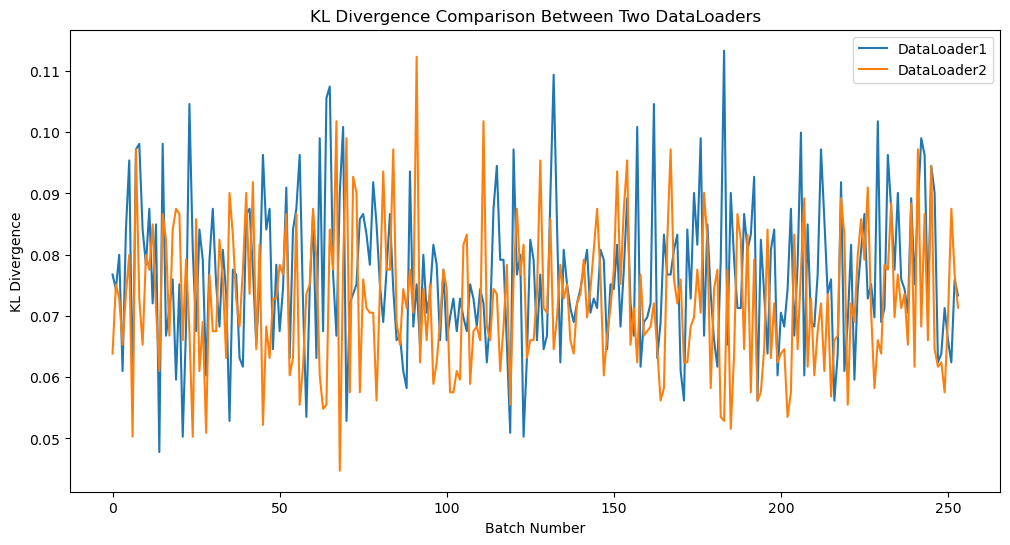

In [9]:
# KL Divergence Comparison Plots
comparison_kl.plot_kl_divergences(kl_divergences_a, kl_divergences_b)

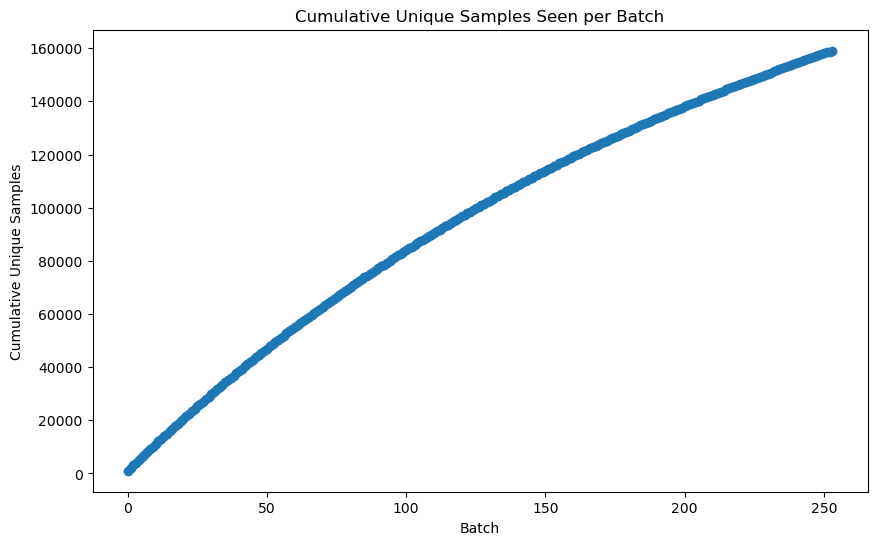

In [10]:
# Most images picked per batch
comparison_kl.plot_unique_samples_scatter(b_unique_images_per_batch)

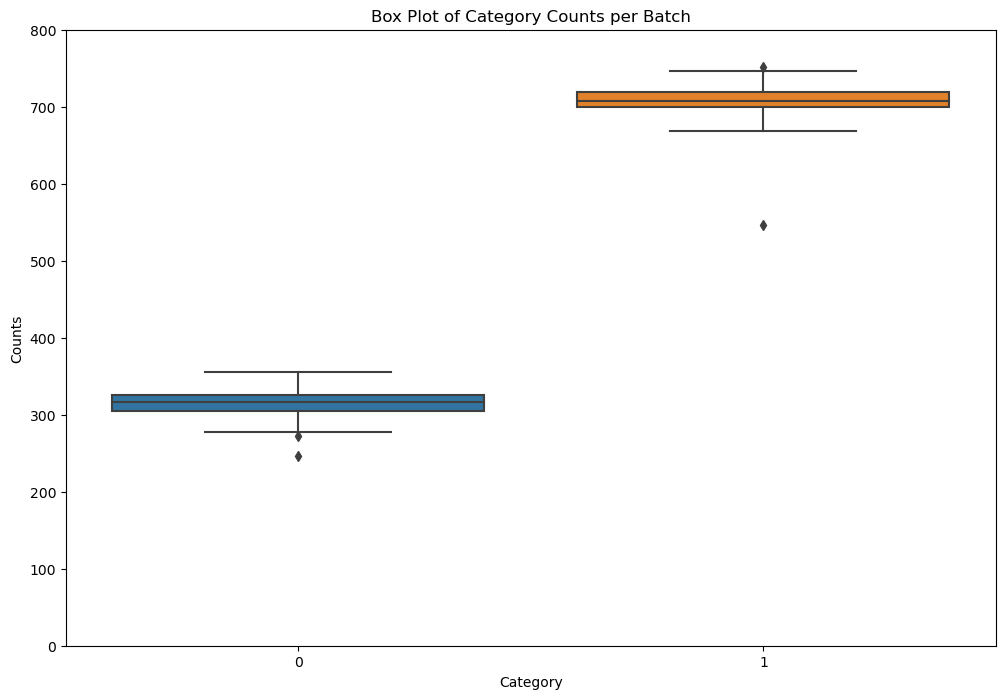

In [11]:
# Category Count Box Plot Count_a -> Dataloader 1
fixed_y_scale = (0, 800)
comparison_kl.plot_category_counts_boxplot(counts_a, y_lim=fixed_y_scale)

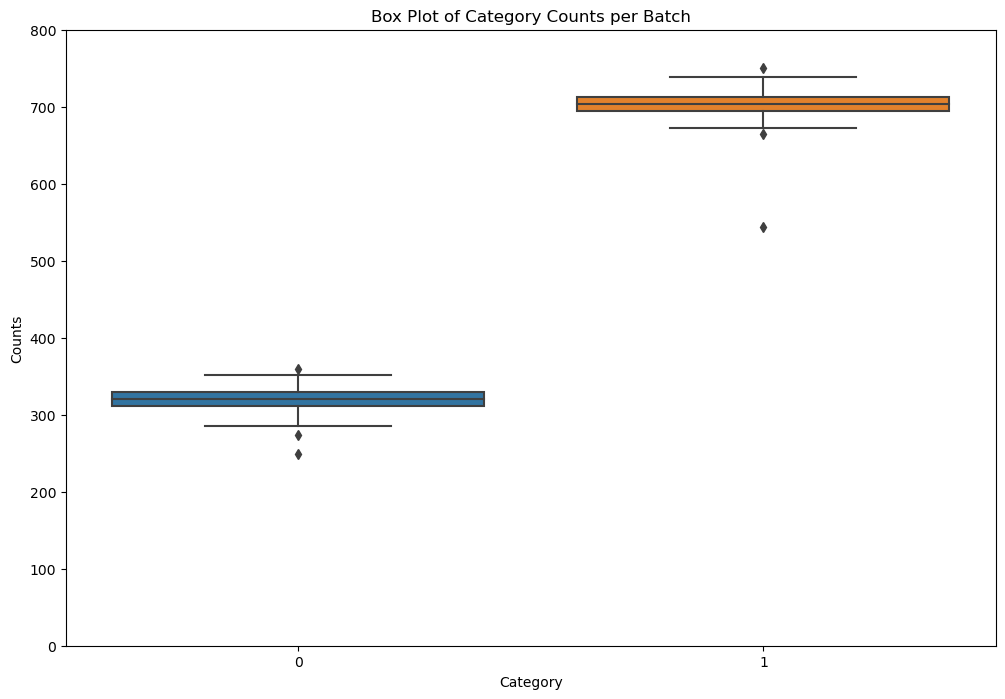

In [12]:
# Category Count Box Plot Count_a -> Dataloader 1
comparison_kl.plot_category_counts_boxplot(counts_b, y_lim=fixed_y_scale)

In [13]:
def plot_category_counts_boxplot_manual(category_counts, y_lim=None):
    plt.figure(figsize=(5, 5))
    sns.boxplot(data=category_counts)
    plt.title("Box Plot of Category Counts per Batch")
    plt.xlabel("Category")
    plt.ylabel("Counts")

    if y_lim is not None:
        plt.ylim(y_lim)
    plt.show()

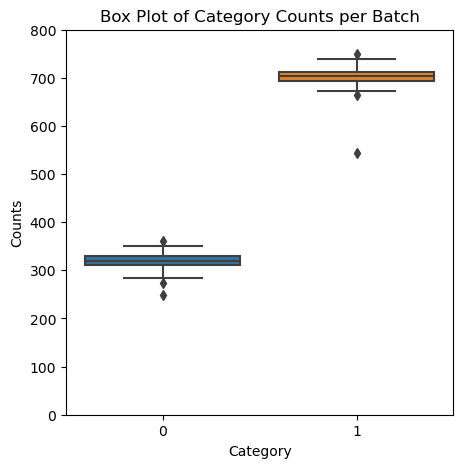

In [14]:
plot_category_counts_boxplot_manual(counts_b, y_lim=fixed_y_scale)

# Interpretation
- Values of KL Divergence:
- A value of 0 indicates that the actual distribution perfectly matches the uniform distribution — there is no divergence between what is observed and what is expected under uniformity.
- Values greater than 0 indicate a divergence from the uniform distribution. The larger the value, the greater the divergence, implying a more uneven distribution of categories within that batch.
# Purpose:
- These values are used to assess how uniformly categories are represented in each batch of DataLoader A. High divergence might suggest biases or sampling errors in how data is being batched, which can be crucial for training machine learning models where balanced data can significantly affect performance.

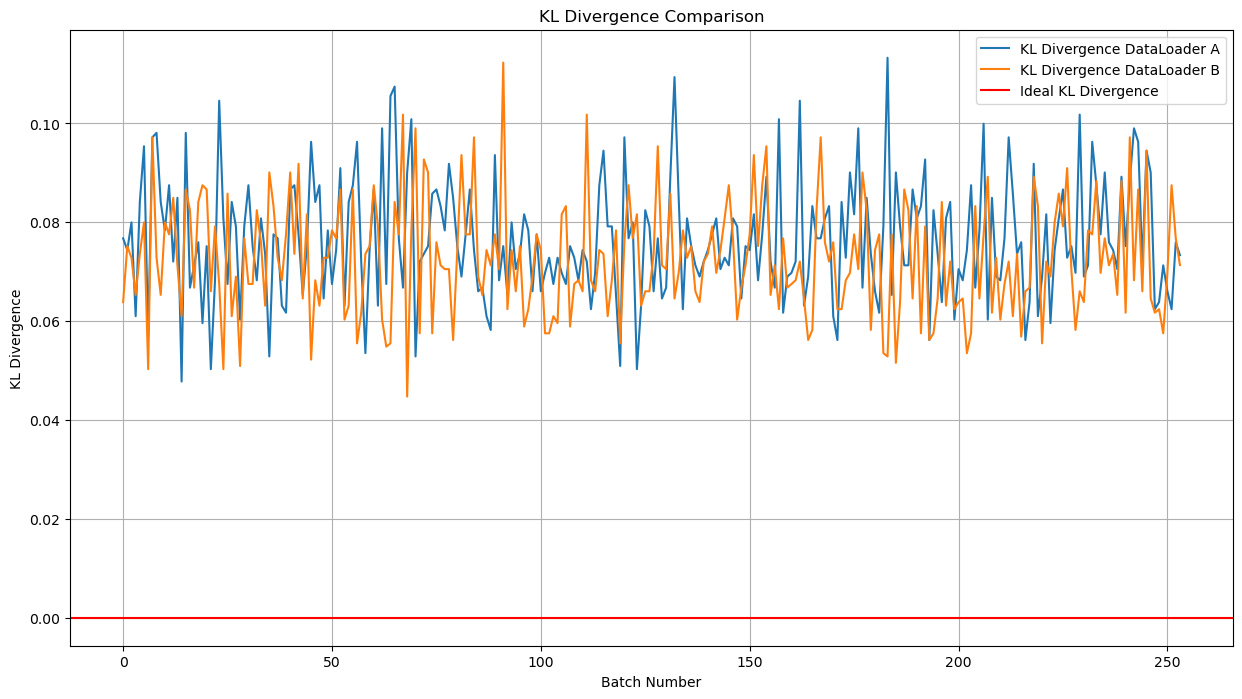

In [15]:
import matplotlib.pyplot as plt

def plot_kl_divergences_with_uniform(kl_div_a, kl_div_b):

    # Plotting the results
    plt.figure(figsize=(15, 8))
    plt.plot(kl_div_a, label='KL Divergence DataLoader A')
    plt.plot(kl_div_b, label='KL Divergence DataLoader B')
    #plt.plot(kl_div_uniform_a, label='Uniform Distribution KL Div DataLoader A', linestyle='--')
    #plt.plot(kl_div_uniform_b, label='Uniform Distribution KL Div DataLoader B', linestyle='--')
    plt.axhline(y=0, color='r', linestyle='-', label='Ideal KL Divergence')
    plt.xlabel('Batch Number')
    plt.ylabel('KL Divergence')
    plt.title('KL Divergence Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage (assuming 'dataloader_comparison_kl_instance' is an instance of your DataLoaderComparisonKL class)
plot_kl_divergences_with_uniform(kl_divergences_a, kl_divergences_b)